# Parent Hamiltonian as a benchmark problem for variational quantum eigensolvers

**parent Hamiltonianの生成**

以下の図のansatzにランダムにパラメータを与えることで生成される量子状態のMPSから、parent HamiltonianをPauli積の和として出力するプログラム。

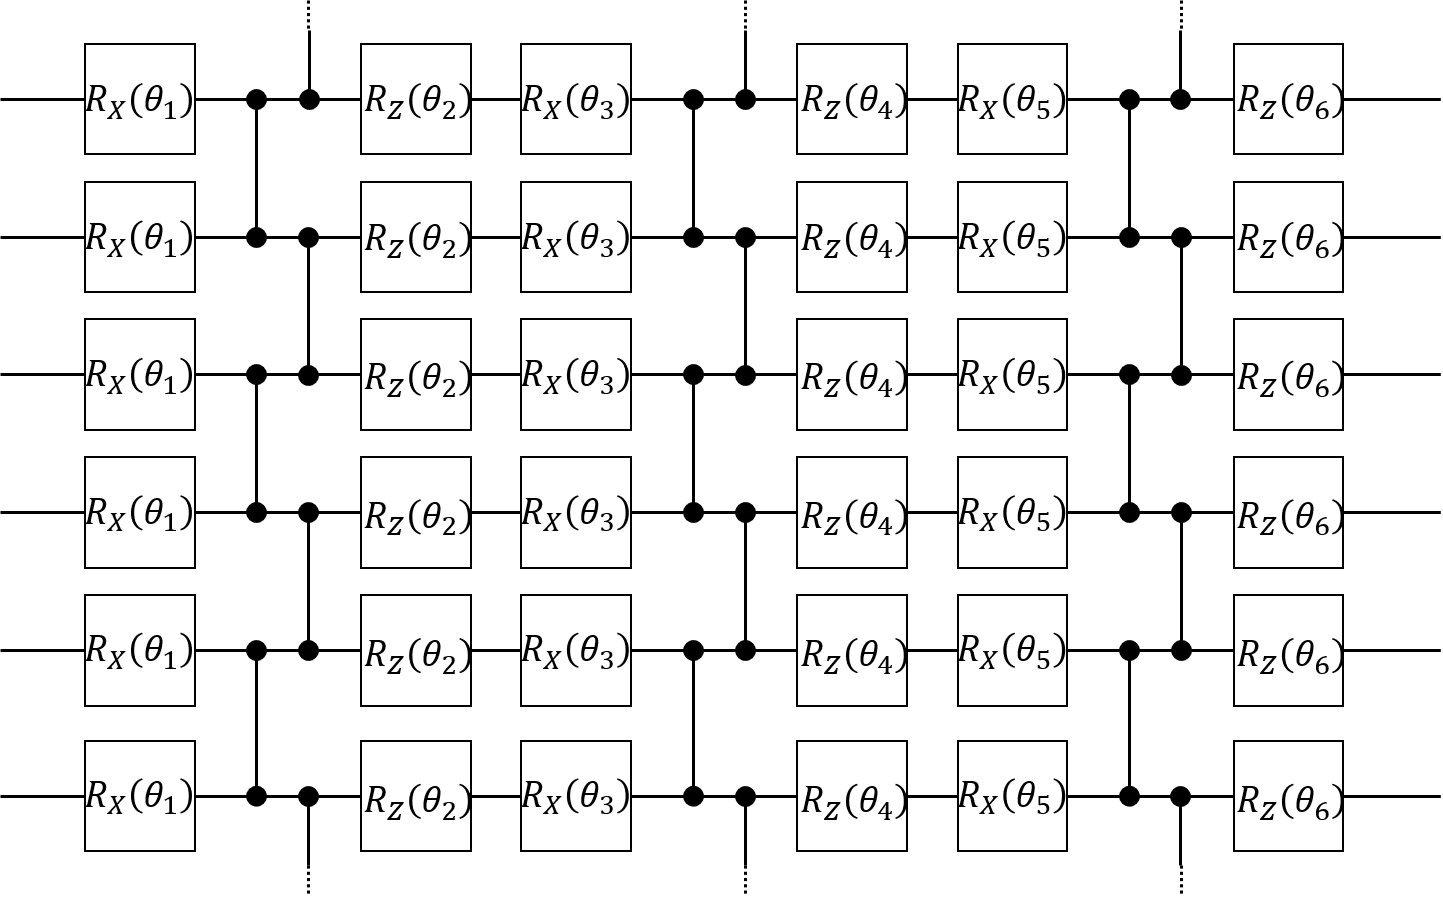

プログラムを実行するとランダムシードの番号とqubit数を聞かれるので指定する。

※ 今回のansatzに対するparent Hamiltonianの基底状態は、12-qubit以上でが一意に定まることが保証される。



In [ ]:
import numpy as np
# import cupy as cp
from scipy import linalg
import string
from time import time

from joblib import Parallel, delayed

def Base_10_to_2_list(X, nqubit):
    binX = bin(X)
    binX = binX[2:]
    L = '{:0>'+str(nqubit)+'}'
    binX = L.format(binX)
    binX = list(binX)
    binX = [int(i) for i in binX]
    return binX


def Zrotation(angle):
    U = np.array([
    [np.exp(-0.5j*angle), 0],
    [0, np.exp(0.5j*angle)]
    ])
    return U

#Original Zrotation
#def Zrotation(angle):
#    U = np.array([
#    [np.exp(0.5j*angle), 0],
#    [0, np.exp(-0.5j*angle)]
#    ])
#    return U

def Xrotation(angle):
    U = np.array([
    [np.cos(0.5*angle), -1j*np.sin(0.5*angle)],
    [-1j*np.sin(0.5*angle), np.cos(0.5*angle)]
    ])
    return U

#def Xrotation(angle):
#    U = np.array([
#    [np.cos(0.5*angle), 1j*np.sin(0.5*angle)],
#    [1j*np.sin(0.5*angle), np.cos(0.5*angle)]
#    ])
#    return U


def Phasechange_gate():
    U = np.array([
    [1,  1],
    [1, -1]
    ])
    return U

def Deltatenor():
    deltaijk = np.zeros((2,2,2))
    deltaijk[0][0][0] = 1
    deltaijk[1][1][1] = 1
    return deltaijk

def Zero_ket():
    zero_ket = np.array(
    [1, 0])
    return zero_ket


def One_qubit_d3_Ansatz_unit(angle0, angle1,angle2, angle3,angle4, angle5):
    Xrot0 = Xrotation(angle0)
    Zrot0 = Zrotation(angle1)
    Xrot1 = Xrotation(angle2)
    Zrot1 = Zrotation(angle3)
    Xrot2 = Xrotation(angle4)
    Zrot2 = Zrotation(angle5)
    phasechange_gate = Phasechange_gate()
    deltatenor = Deltatenor()
    zero_ket = Zero_ket()

    unit0 = np.einsum('AB, BCi, jCD, jk, DE, E -> Aik', Zrot0, deltatenor, deltatenor, phasechange_gate, Xrot0, zero_ket)
    unit1 = np.einsum('AB, BCi, jCD, jk, DE -> AEik', Zrot1, deltatenor, deltatenor, phasechange_gate, Xrot1)
    unit2 = np.einsum('AB, BCi, jCD, jk, DE -> AEik', Zrot2, deltatenor, deltatenor, phasechange_gate, Xrot2)
    unit = np.einsum('ABij, BCkl, Cmn -> Aijklmn', unit2, unit1, unit0)
    return unit

# nqubit, depth:3
def Nqubit_MPS(nqubit, angle_list):
    unit = One_qubit_d3_Ansatz_unit(angle_list[0], angle_list[1], angle_list[2], angle_list[3], angle_list[4], angle_list[5])

    ABC = list(string.ascii_uppercase)
    index_segment = ''
    physical_index1 = 'A'
    state = unit
    for n in range(1,nqubit):
        physical_index2 = ABC[n]
        index_segment = '{0}ijklmn, {1}jolpnq -> {0}{1}iokpmq'.format(physical_index1, physical_index2)
        state = np.einsum(index_segment, state, unit)
        print(index_segment)
        physical_index1 += physical_index2

    print('{0}iijjkk -> {0}'.format(physical_index1))
    state = np.einsum('{0}iijjkk -> {0}'.format(physical_index1), state)
    state_conj = np.conj(state)
    return state, state_conj, physical_index1


### MPS
def Nqubit_state_locality_checker(nqubit):
    print('enter a int number of random seed')
    randomseed = int(input())
    np.random.seed(seed= randomseed)
    angle_list = np.random.rand(depth*2)*2*np.pi
    print("Answer_angle_list: ", angle_list)
    state, state_conj, physical_index = Nqubit_MPS(nqubit, angle_list)
    renomal_const = np.sqrt(np.einsum(physical_index+','+physical_index, state, state_conj))
    print("<state|state>: ",renomal_const)

    flag = 1
    abc = string.ascii_lowercase
    for i in range(2,nqubit):
        if flag ==0:
            pass
        elif i<nqubit:
            physical_index_conj = abc[:i]
            index_temp = '{0}, {1}{2} -> {3}{1}'.format(
                physical_index, physical_index_conj, physical_index[i:], physical_index[:i]) # 大文字:MPSのphysicalindex,小文字:密度演算子に残すMPS_conjのphysicalindex
            rho = np.einsum(index_temp, state, state_conj)
            print(index_temp)
            rho_matrix = rho.reshape(2**i,2**i)
            rank = np.linalg.matrix_rank(rho_matrix)
            print('{0}-local density matrix rank:{1}(full_rank:{2})'.format(i,rank,2**i))
            if rank < 2**i:
                flag = 0
                local = i
                print('{}-local state'.format(i))
            else:
                pass
        else:
            print('subspace size is higher than {}'.format(nqubit)) #とりあえず4体で打ち止め
            break
    return rho_matrix, rank, local, angle_list, state



### 
def Null_projector(rho_matrix, rank, local):
    matrix_size = 2**local
    null_space = linalg.null_space(rho_matrix)
    #print(np.linalg.matrix_rank(null_space))
    null_projector = 0
    for i in range(matrix_size - rank):
        null_vec = null_space[:,i]
        null_vec = null_vec.reshape(matrix_size,1)
        null_vec_mat = null_vec @ np.conj(null_vec.T)
        null_projector += null_vec_mat
    return null_projector, matrix_size

def Paulioperator(i):
    if i == 0:
        p = np.identity(2, dtype=np.complex128)
    elif i == 1:
        p = np.array( [[0, 1], [1, 0]])
    elif i == 2:
        p = np.array( [[0, -1j], [1j, 0]])
    elif i == 3:
        p = np.array( [[1, 0], [0, -1]])
    return p




def Base_10_to_n(X, n):
    if (int(X/n)):
        return Base_10_to_n(int(X/n), n)+str(X%n)
    return str(X%n)

def Process_pauliproduct(i, nqubit, local, null_projector):
    l = Base_10_to_n(i, 4)
    size = '{:0>'+str(local)+'}'
    l = size.format(l)
    lis = list(l)
    lis = [int(s) for s in lis]
    #Pauli
    pauliproduct_temp =1
    for j in range(local):
        pauliproduct_temp =np.kron(pauliproduct_temp , Paulioperator(lis[j]))
    paulimatrix = pauliproduct_temp
    print(paulimatrix)
    pauliproducts_factor = np.einsum('ij,ij->', np.conj(null_projector), paulimatrix)/(2**local) # これが早いらしい
    #Pauli
    pauli_product_str = l.replace("0", "I").replace("1", "X").replace("2", "Y").replace("3", "Z")
    pauli_product_lis = list(pauli_product_str)
    pauliproducts_factor_templist = []
    for m in range(nqubit):
        pauli_product=""
        for k in range(local-1):
            pauli_product += str(pauli_product_lis[k]) + " " + str((k+m)%nqubit) + " "
        pauli_product += str(pauli_product_lis[local-1]) + " " + str((local-1+m)%nqubit)
        pauliproducts_factor_templist.append((pauliproducts_factor.real, pauli_product))
    return pauliproducts_factor_templist


def Parent_Hamiltonian_Paulirepresentation(nqubit):
    rho_matrix, rank, local, answer_angle_list, state = Nqubit_state_locality_checker(nqubit)
    print("(rank, local):", (rank, local))
    null_projector, matrix_size = Null_projector(rho_matrix, rank, local)
    print('Parent Hamiltonian Projector preparation is complete')
    print('Projector rank', np.linalg.matrix_rank(null_projector))
  
    pauliproducts_factor_list = []
    parallel_list = Parallel(n_jobs=-1, verbose=8)( [delayed(Process_pauliproduct)(i, nqubit, local, null_projector) for i in range(4**local)] )
    for i in range(4**local):
        pauliproducts_factor_list +=parallel_list[i]
    print(pauliproducts_factor_list)
    return pauliproducts_factor_list, answer_angle_list, state




## Code for Creating the Parent Hamiltonian

In [ ]:
print("This is MPS and Parent Hamiltonian Generator.")

#print("Please type the number of qubit.")
nqubit = 3

print("The number of qubit = {}".format(nqubit))
# nqubit = 6

depth = 3
start = time()

pauliproducts_factor_list, answer_angle_list, MPS_vec= Parent_Hamiltonian_Paulirepresentation(
    nqubit)

print('Prepared Parent Hamiltonian!')
print('Calculation time: {}(sec)'.format(time() - start))

In [ ]:
# The selected Angles
answer_angle_list

In [ ]:
# The Hamiltonian
pauliproducts_factor_list

## QLM Implementation

In [ ]:
import qat.lang.AQASM as qlm
from qat.core import Observable, Term
import re
import ast
import matplotlib.pyplot as plt

In the following cell we are going to adapt the Hamiltonian Terms from *pauliproducts_factor_list* to a list that **QLM** can handle

In [ ]:
#We need to change Hamiltonian between ParentHamiltonian and QLM Observables
list_of_terms = []
for pauli in pauliproducts_factor_list:
    step = pauli[1]
    #first we pick the letters
    a=re.findall(r'[A-Z]', step)
    #second we pick the number
    b = re.findall(r'\d+', step)
    #We create the QLM Term object: Term(coefficient, gates, qbits where gates are applied)
    list_of_terms.append(
        Term(pauli[0], ''.join(a), [int(i) for i in b])
    )
#With the list of QLM Terms we create the QLM Observable object
obs = Observable(nqubit, pauli_terms=list_of_terms)

Now we implement the ansatz in QLM langauge

In [ ]:
# The ansatz in QLM langauge
#We are going to aaause a QLM parametric circuit!!

qprog = qlm.Program()
qbits = qprog.qalloc(nqubit)

#Parameters for the PQC
theta = [qprog.new_var(float, "\\theta_{}".format(i)) for i in range(2*depth)]

for d in range(0, 2*depth, 2):
    for i in range(nqubit):
        qprog.apply(qlm.RX(theta[d]), qbits[i])
    for i in range(nqubit-1):
        qprog.apply(qlm.Z.ctrl(), qbits[i], qbits[i+1])
    qprog.apply(qlm.Z.ctrl(), qbits[nqubit-1], qbits[0])
    for i in range(nqubit):
        qprog.apply(qlm.RZ(theta[d+1]), qbits[i])
circuit = qprog.to_circ()        

In [ ]:
%qatdisplay circuit --svg

Now we need to load in memory the linear algebra solvers from QLM. There are two:

1. PyLinalg: lineal algebra solver in python
1. CLinalg: lineal algebra solver in c

In [ ]:
#QLM QPUs
from qat.qpus import PyLinalg, CLinalg
qpu = PyLinalg()

## Evaluacion

Now we are going to compute the complete system. This computation consist:

1. Using the ansatz compute the measurement of each term of the observable.
2. Each measurement will be multiplied by the correspondent coefficient.
3. All the elements will be summed and this will be the energy of the ansatz under the complete parent Hamiltonian.

For doing this in qlm we have to create a QLM *job* object. The qlm has two modes:

1. Pure messure mode: they measure the qubits of the circuit so a measurement will be: 001, 100, 111 etc..
2. Observable measure: the measure the observable of the operator you provide (this is the mode we need!)

In [ ]:
#QLM job from circuit. In Observable Mode!!
job = circuit.to_job('OBS', observable=obs)

When we create the ansatz we use parametric gates so the rotatios are in function of variables. We need to provide numbers to these variables!! In the next cell we are giving to the variable the optimal parameters!

In [ ]:
#We are going to fix the parameters of the PQC to the ideal ones!!
job_eval = job(** {v: answer_angle_list[i] for i,v in enumerate(job.get_variables())})

Now we have properly configured the job. So wee need to provide the job to the QLM solver for getting the results. This is done in the following cell

In [ ]:
#We submit the job to the QPU
r_eval = qpu.submit(job_eval)

*r_eval* is an object with all the info of the resulting simulation. As can be seen has an ugly format!!

In [ ]:
r_eval

The energy is provided by the *value* atribute!

In [ ]:
# This is the Energy. This should be near zero
r_eval.value

## QLM StateVector Computation

Main problem is given a circuit how can I get the MPS representation of the ansatz circuit???

**BE AWARE**

The following are my thoughs that I expect that works but I am not 100% sure...

The MPS is really a fancy way to order the different amplitudes of the final state of the ansatz (**only the ansatz**). So a priori we could implement the circuit in any suitable language (*QLM*, *Qiskit*, *Qulacs* ...) simulate the circuit and get the state vector. The state vector will provide us the different amplitudes of the final state of the ansatz so we need only to reshape this information in an MPS suitable way.

Go ahead!!


In [ ]:
#This a function for getting a beautiful view of the simulation resultszz
import pandas as pd
def proccess_qresults(result, qubits, complete=False):
    """
    Post Process a QLM results for creating a pandas DataFrame

    Parameters
    ----------

    result : QLM results from a QLM qpu.
        returned object from a qpu submit
    qubits : int
        number of qubits
    complete : bool
        for return the complete basis state.
    """

    # Process the results
    if complete:
        states = []
        list_int = []
        list_int_lsb = []
        for i in range(2**qubits):
            reversed_i = int("{:0{width}b}".format(i, width=qubits)[::-1], 2)
            list_int.append(reversed_i)
            list_int_lsb.append(i)
            states.append("|" + bin(i)[2:].zfill(qubits) + ">")

        probability = np.zeros(2**qubits)
        amplitude = np.zeros(2**qubits, dtype=np.complex_)
        for samples in result:
            probability[samples.state.lsb_int] = samples.probability
            amplitude[samples.state.lsb_int] = samples.amplitude

        pdf = pd.DataFrame(
            {
                "States": states,
                "Int_lsb": list_int_lsb,
                "Probability": probability,
                "Amplitude": amplitude,
                "Int": list_int,
            }
        )
    else:
        list_for_results = []
        for sample in result:
            list_for_results.append([
                sample.state, sample.state.lsb_int, sample.probability,
                sample.amplitude, sample.state.int,
            ])

        pdf = pd.DataFrame(
            list_for_results,
            columns=['States', "Int_lsb", "Probability", "Amplitude", "Int"]
        )
        pdf.sort_values(["Int_lsb"], inplace=True)
    return pdf

Now we need to measure the qubits so we need the *QLM* job but not in observable mode (we need the other mode).

In [ ]:
#QLM job from circuit. In Meaure Mode!!
job = circuit.to_job()
#here we set the parameter to the optimal angles
job_linearA = job(** {v: answer_angle_list[i] for i,v in enumerate(job.get_variables())})
qpu_py = PyLinalg()
qpu_c = CLinalg()

In [ ]:
#Submit the job 
results_py = qpu_py.submit(job_linearA)

As before the *result* object is ugly

In [ ]:
results_py

we can give the results objet to the *proccess_qresults* for getting a more beatifull view of the results

In [ ]:
pdf_result = proccess_qresults(results_py, nqubit, True)

In [ ]:
pdf_result

So now we have the complete list of amplitudes for the final state of the ansatz. So we need to change to MPS format!!

In [ ]:
#first convert to numpy array
amplitudes = pdf_result[['Amplitude']].to_numpy()
#for MPS we need to create a nqubit-rank tensor
qlm_mps = amplitudes.reshape([2 for i in range(nqubit)])

Now we are going to compare our computed *MPS* with the *MPS* of the ansatz computed with the parent hamiltonian software (*MPS_vec*)

In [ ]:
np.isclose(qlm_mps, MPS_vec).all()

So the MPS computed by the parent hamiltonian software is the same that the MPS that we compute using QLM... My theory is that we can use the MPS computed by QLM with the parent hamiltonian functions for getting the hamiltonian term list.... 

In [ ]:
qlm_mps.shape

In [ ]:
#This cell show how to analize a QLM  results object
for state in results_py:
    print(state.state, state.probability, state.amplitude, state.state.int, state.state.lsb_int)

### MPS QLM Solver

If the ansatz have a lot of qubits the state vector computation can be slowly. We could use the *MPS* solver form the *QLM* software. They claim the *MPS* software have a better performance!!. You need the private version and acces to QLM hardware

In [ ]:
from qlmaas.qpus import MPS

In [ ]:
%qatdisplay circuit --svg

In [ ]:
#QLM job from circuit. In Observable Mode!!
job_mps = circuit.to_job()
job_mps = job_mps(** {v: answer_angle_list[i] for i,v in enumerate(job.get_variables())})
qpu_mps = MPS(lnnize =True)
result_mps = proccess_qresults(
    qpu_mps.submit(
        job_mps
    ).join(),
    nqubit,
    True
)

In [ ]:
result_mps

In [ ]:
atos_mps = result_mps[['Amplitude']].to_numpy()

In [ ]:
atos_mps

In [ ]:
np.isclose(atos_mps.reshape((2,2,2)), MPS_vec).all()

### Optimizacion

Here we show how to use the *QLM* for doing an optimisation procces. Here we need two components:

1. The QPU component.
2. An optimizer. In QLM this is implemented using a QLM object called Plugins. These Plugins offer more functionalities than optimisation. For the moment we are going to use a optimization plugin

In [ ]:
# For doing the optimisation!
from qat.plugins import ScipyMinimizePlugin
job_opt = circuit.to_job('OBS', observable=obs)
optimizer_scipy = ScipyMinimizePlugin(
    method="COBYLA",
    tol=1e-6,
    options={"maxiter": 200},
    x0= [np.random.random() for i in answer_angle_list] #here we need to provide the initial angles
)
stack = optimizer_scipy | qpu
result_opt = stack.submit(job_opt)

In [ ]:
#Obtained minimum energy form op`timisation
print(f"Minimum VQE energy ={result_opt.value}")

In [ ]:
opt_par = ast.literal_eval(result_opt.meta_data['parameters'])

In [ ]:
opt_par

In [ ]:
answer_angle_list

In [ ]:
plt.plot(eval(result_opt.meta_data['optimization_trace']), 'o-')

## QULACS Program

上記のプログラムで使用したランダムパラメータは、
```
Answer_angle_list = [2.62022653e+00 4.52593227e+00 7.18638172e-04 1.89961158e+00
 9.22094457e-01 5.80180502e-01]
```
として、出力されたparent Hamiltonianのpauli積と係数は

```
pauliproducts_factor_list =[(0.4999999999999999, 'I 0 I 1 I 2 I 3'), (0.4999999999999999, 'I 1 I 2 I 3 I 4'), ...]
```
として書き出されている。

これはqulacsのobservableを指定する形式で出力されるため、optimizerのベンチマーク問題として利用する場合は、以下のVQEシミュレータのoptimizerを所望のoptimizerに変更するか、自作のシミュレータで上記のlistをobservbleとして以下のように読み込んでください。
```
def Make_Parent_Hamiltonian(nqubit, pauliproducts_factor_list):
    hamiltonian = pauliproducts_factor_list
    observable = Observable(nqubit)
    for (coef, Pauli_string) in  hamiltonian:
        observable.add_operator(coef, Pauli_string)
    return observable
```

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import qulacs
from scipy.optimize import minimize
from qulacs import QuantumState, QuantumCircuit,  Observable, ParametricQuantumCircuit
from qulacs.gate import X, Y, Z, RX, RY, RZ, CZ, PauliRotation, DenseMatrix, merge, to_matrix_gate
from sympy.physics.quantum.qubit import matrix_to_qubit
import datetime
#from google.colab import files

# Parametricで作るとき
def ansatz_circuit(nqubit, depth, angle_list):
    circuit = ParametricQuantumCircuit(nqubit)
    for d in range(0, 2*depth, 2):
      for i in range(nqubit):
        circuit.add_parametric_RX_gate(i, angle_list[d]) # = exp(i angle/2 X_i)
      for i in range(nqubit-1):
        circuit.add_gate(CZ(i, i+1))
      circuit.add_gate(CZ(nqubit-1, 0))
      for i in range(nqubit):
        circuit.add_parametric_RZ_gate(i, angle_list[d+1]) # = exp(i angle/2 Z_i)
    return circuit


#creating pearent hamiltonian
def Make_Parent_Hamiltonian(nqubit, pauliproducts_factor_list):
    hamiltonian = pauliproducts_factor_list
    observable = Observable(nqubit)
    for (coef, Pauli_string) in  hamiltonian:
        observable.add_operator(coef, Pauli_string)
    return observable


def cost(angle_list):
    state = QuantumState(nqubit) #|00000> を準備
    state.set_zero_state()
    for d in range(0, 2*depth, 2): # Parametricで作るとき
      for n in range(nqubit):
        circuit.set_parameter(d*nqubit+n, angle_list[d])
      for i in range(nqubit):
        circuit.set_parameter((d+1)*nqubit+i, angle_list[d+1])
    circuit.update_quantum_state(state) #量子回路を状態に作用
    expectationrnregy = hamiltonian.get_expectation_value(state)
    return expectationrnregy #ハミルトニアンの期待値を計算



def main():
    global nqubit, depth, hamiltonian, circuit
    print("This is Variational Quantum Eigensolver.")
    # print("Please type the number of qubit.")
    # nqubit = int(input())
    print("The number of qubit = {}".format(nqubit))
    depth = 3

    start = time()
    ### VQEによるエネルギー推定 ###
    circuit = ansatz_circuit(nqubit, depth, answer_angle_list)
    # parameter_count = circuit.get_parameter_count()
    # print('number of circuit parameter:', parameter_count)
    
    hamiltonian = Make_Parent_Hamiltonian(nqubit, pauliproducts_factor_list)
    print("Exact ground Energy: ",cost(answer_angle_list))
    print('One-step calc time: {}(sec)'.format(time() - start))

    # init_angle_list = answer_angle_list + (1-np.random.rand(depth*2)*2)
    init_angle_list = np.random.rand(depth*2)*2*np.pi


    def It_Value_append(x, cost_history):
      cost_history.append(cost(x))
      print('Optimization time: {}(sec)'.format(time() - start))
      return cost_history

    cost_history1 = [] 
    cost_history1.append(cost(init_angle_list))
    method1 = "BFGS"
    options = {"disp": True, "maxiter": 100, "gtol": 1e-6}
    opt1 = minimize(cost, init_angle_list, 
                    method=method1, 
                    options=options,
                    callback=lambda x: It_Value_append(x,cost_history1))
                    # callback=lambda x: cost_history1.append(cost(x)))

    cost_history2 = []
    cost_history2.append(cost(init_angle_list))
    method2 = "Powell"
    options = {"disp": True, "maxiter": 100, "xtol": 1e-10, "ftol":1e-6}
    opt2 = minimize(cost, init_angle_list, 
                    method=method2, 
                    options=options,
                    callback=lambda x: It_Value_append(x,cost_history2))


    cost_history3 = []
    cost_history3.append(cost(init_angle_list))
    method3 = "CG"
    options = {"disp": True, "maxiter": 100, "gtol": 1e-6}
    opt3 = minimize(cost, init_angle_list, 
                    method=method3, 
                    options=options,
                    callback=lambda x: It_Value_append(x,cost_history3))

    cost_history4 = []
    cost_history4.append(cost(init_angle_list))
    method4 = "SLSQP"
    options = {"disp": True, "maxiter": 100, "gtol": 1e-6}
    opt4 = minimize(cost, init_angle_list, 
                    method=method4, 
                    options=options,
                    callback=lambda x: It_Value_append(x,cost_history4))

    
    # グラフ描画部分
    fig = plt.figure(tight_layout = True)
    # add_subplot()でグラフを描画する領域を追加する．引数は行，列，場所
    ax1 = fig.add_subplot(1, 1, 1,  xlabel='Iteration', ylabel='Energy expectation value')
    
    plt.rcParams["font.size"] = 10
    ax1.grid(axis='y', color='black', lw=0.5, ls='--')
    ax1.plot(cost_history1, label=method1)
    ax1.plot(cost_history2, label=method2)
    ax1.plot(cost_history3, label=method3)
    ax1.plot(cost_history4, label=method4)
    ax1.legend()

    boxdic = {"facecolor" : "white", "boxstyle": 'square', "alpha" : 0.5}
    fig.text(0.05, 1, 
    str(method1)+" angle:"+str(opt1.x)+"\n"+
    str(method2)+" angle:"+str(opt2.x)+"\n"+
    str(method3)+" angle:"+str(opt3.x)+"\n"+
    str(method4)+" angle:"+str(opt4.x)+"\n"+
    "Answer angle:"+str(answer_angle_list)# +"\n"+
    # str(method1)+" number of function evaluation:"+str(opt1.nfev)+"\n"+
    # str(method2)+" number of function evaluation:"+str(opt2.nfev)+"\n"+
    # str(method3)+" number of function evaluation:"+str(opt3.nfev)+"\n"+
    # str(method4)+" number of function evaluation:"+str(opt4.nfev)
    , fontsize=10, fontdict=None, bbox=boxdic)

    now = datetime.datetime.now()
    plt.savefig("{0}-qubit_depth{1}_{2}.svg".format(nqubit, depth, now.strftime('%y%m%d_%H%M')), bbox_inches = "tight", format='svg')
    #files.download("{0}-qubit_depth{1}_{2}.svg".format(nqubit, depth, now.strftime('%y%m%d_%H%M')))
    plt.show()
    print('Finish Optimization time: {}(sec)'.format(time() - start))


#if __name__ == '__main__':
#    main()

In [ ]:
    global nqubit, depth, hamiltonian, circuit
    print("This is Variational Quantum Eigensolver.")
    # print("Please type the number of qubit.")
    # nqubit = int(input())
    print("The number of qubit = {}".format(nqubit))
    depth = 3

    start = time()
    ### VQEによるエネルギー推定 ###
    circuit = ansatz_circuit(nqubit, depth, answer_angle_list)
    hamiltonian = Make_Parent_Hamiltonian(nqubit, pauliproducts_factor_list)
    print("Exact ground Energy: ",cost(answer_angle_list))
    print('One-step calc time: {}(sec)'.format(time() - start))

In [ ]:
a= hamiltonian.get_term(2)

In [ ]:
a.get_pauli_string()

In [ ]:
pauliproducts_factor_list[5]

In [ ]:
ob.terms

In [ ]:
from qulacsvis import circuit_drawer

In [ ]:
circuit_drawer(circuit)